# 0-D Supply Utilization Model


In [244]:
Ind_Use = pd.read_csv(r"C:\Users\danie\Downloads\share-cereals-industrial-uses.csv")

In [251]:
Ind_Use.Entity.unique() 

array(['Afghanistan', 'Africa', 'Africa (FAO)', 'Albania', 'Algeria',
       'Americas (FAO)', 'Angola', 'Antigua and Barbuda', 'Argentina',
       'Armenia', 'Asia', 'Asia (FAO)', 'Australia', 'Austria',
       'Azerbaijan', 'Bahamas', 'Bahrain', 'Bangladesh', 'Barbados',
       'Belarus', 'Belgium', 'Belgium-Luxembourg (FAO)', 'Belize',
       'Benin', 'Bermuda', 'Bhutan', 'Bolivia', 'Bosnia and Herzegovina',
       'Botswana', 'Brazil', 'Brunei', 'Bulgaria', 'Burkina Faso',
       'Burundi', 'Cambodia', 'Cameroon', 'Canada', 'Cape Verde',
       'Caribbean (FAO)', 'Central African Republic',
       'Central America (FAO)', 'Central Asia (FAO)', 'Chile', 'China',
       'China (FAO)', 'Colombia', 'Congo', 'Costa Rica', "Cote d'Ivoire",
       'Croatia', 'Cuba', 'Cyprus', 'Czechia', 'Denmark', 'Djibouti',
       'Dominica', 'Dominican Republic', 'East Timor',
       'Eastern Africa (FAO)', 'Eastern Asia (FAO)',
       'Eastern Europe (FAO)', 'Ecuador', 'Egypt', 'El Salvador',
       '

In [259]:
np.sort(Ind_Use.Year.unique())

array([1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971,
       1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982,
       1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993,
       1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004,
       2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015,
       2016, 2017, 2018, 2019, 2020, 2021, 2022], dtype=int64)

In [255]:
World_otheruse = Ind_Use[Ind_Use['Entity']=='World']['Share of cereals that are allocated to other uses such as biofuel production'].values

In [92]:
Food_Balance = pd.read_csv(r"..\Data\0DSUM\cereals-food-balance.csv")

In [95]:
Food_Balance.Element.unique()

array(['Production', 'Import quantity', 'Stock Variation',
       'Export quantity', 'Domestic supply quantity', 'Feed', 'Seed',
       'Losses', 'Processing', 'Other uses (non-food)',
       'Tourist consumption', 'Residuals', 'Food',
       'Food supply quantity (kg/capita/yr)',
       'Food supply (kcal/capita/day)', 'Food supply (kcal)',
       'Protein supply quantity (g/capita/day)',
       'Protein supply quantity (t)',
       'Fat supply quantity (g/capita/day)', 'Fat supply quantity (t)'],
      dtype=object)

In [100]:
Food_Balance[(Food_Balance.Element == 'Processing') & (Food_Balance.Year == 2010)]

,Domain Code,Domain,Area Code (M49),Area,Element Code,Element,Item Code (FBS),Item,Year Code,Year,Unit,Value,Flag,Flag Description,Note
8,FBS,Food Balances (2010-),1,World,5131,Processing,S2905,Cereals - Excluding Beer,2010,2010,1000 t,108911.0,E,Estimated value,NaN


In [104]:
Feed_proportion = []
Seed_proportion = []
Losses_proportion = []
Processing_proportion = []
Other_uses_proportion = []
Caloric_densities = []
for year in Food_Balance.Year.unique():
    Feed = Food_Balance[(Food_Balance.Element == 'Feed') & (Food_Balance.Year == year)].Value.values[0]
    Seed = Food_Balance[(Food_Balance.Element == 'Seed') & (Food_Balance.Year == year)].Value.values[0]
    Losses = Food_Balance[(Food_Balance.Element == 'Losses') & (Food_Balance.Year == year)].Value.values[0]
    Processing = Food_Balance[(Food_Balance.Element == 'Processing') & (Food_Balance.Year == year)].Value.values[0]
    Other_uses = Food_Balance[(Food_Balance.Element == 'Other uses (non-food)') & (Food_Balance.Year == year)].Value.values[0]
    Production = Food_Balance[(Food_Balance.Element == 'Production') & (Food_Balance.Year == year)].Value.values[0]

    Caloric_density = 1e6*Food_Balance[ (Food_Balance.Element == 'Food supply (kcal)') & (Food_Balance.Year == year)].Value.values[0]*(1/Food_Balance[(Food_Balance.Element == 'Food supply quantity (kg/capita/yr)') & (Food_Balance.Year == year)].Value.values[0])*(1/(Pop_Data[Pop_Data.Year == year].Value.values[0]*1000)) #kcal/year * cap*year/kg * 1/cap= kcal/kg
    
    Feed_proportion.append(Feed/Production)
    Seed_proportion.append(Seed/Production)
    Losses_proportion.append(Losses/Production)
    Processing_proportion.append(Processing/Production)
    Other_uses_proportion.append(Other_uses/Production)
    
    Caloric_densities.append(Caloric_density)



In [105]:
print("Seed proprtion is ", np.mean(Seed_proportion))
print("Feed proprtion is ", np.mean(Feed_proportion))   
print("Losses proprtion is ", np.mean(Losses_proportion))
print("Processing proprtion is ", np.mean(Processing_proportion))
print("Other uses proprtion is ", np.mean(Other_uses_proportion))
print("Caloric density is ", np.mean(Caloric_densities))


Seed proprtion is  0.026636729720242374
Feed proprtion is  0.33680755854898276
Losses proprtion is  0.04362604381094706
Processing proprtion is  0.0420743795443147
Other uses proprtion is  0.08865469481117141
Caloric density is  2609.596450423227


In [283]:
World_otheruse/100

array([0.01387646, 0.01364933, 0.01566266, 0.01589801, 0.024276  ,
       0.01401411, 0.01423654, 0.01292222, 0.01319277, 0.01267623,
       0.01303651, 0.01243995, 0.01192908, 0.01312063, 0.01317408,
       0.01307439, 0.0126299 , 0.01347374, 0.01332538, 0.01367319,
       0.01486852, 0.01636552, 0.01752348, 0.01854311, 0.02012372,
       0.02010245, 0.02589152, 0.02591845, 0.03058428, 0.03787805,
       0.03299031, 0.0279462 , 0.02839922, 0.02736501, 0.03291717,
       0.03531433, 0.03238778, 0.03398675, 0.03536214, 0.03660691,
       0.03751286, 0.04657697, 0.05182385, 0.05583671, 0.06205821,
       0.07019195, 0.08284148, 0.09015816, 0.10577463, 0.10183863,
       0.10038602, 0.09730134, 0.100519  , 0.08932687, 0.0994882 ,
       0.11144176, 0.10709413, 0.09861444, 0.09733933, 0.09970133,
       0.09969617, 0.09038177])

In [453]:
#
#
#
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Production_Data = pd.read_csv("../Data/0DSUM/FAOSTAT_data_en_3-26-2025.csv")
Pop_Data = pd.read_csv("../Data/0DSUM/FAOSTAT_populationglobal.csv")
addit = np.zeros(len(years))
addit[-10:] = 0.04
seed = 0.03
loss = 0.04
processing = 0.04
economic_use = 0.33 + 0.08+addit#0*np.hstack([World_otheruse,World_otheruse[-1]])/100 # 35% for animal consumption. World other use is extended by one year. 
cereal_caloric_density = 2609*1000 # kcal/ton 
caloric_requirment = 1240*365 # 1200 kcal/year

years = Production_Data.Year.unique()
stocks = np.zeros(len(years))-0.01
#stocks[0] = stocks_obs[0]*1000
alpha = np.zeros(len(years))

for i in np.arange(1,len(years)):
    Pop = Pop_Data[Pop_Data.Year == years[i]].Value.values[0]
    Y = Production_Data[Production_Data.Year == years[i]].Value.values[0]
    food = 1000*Pop*caloric_requirment/cereal_caloric_density # in tons

    if stocks[i-1] + (Y*(1-seed-loss) - food*(1+processing+alpha[i]) - Y*economic_use[i]) >= 0:
        alpha[i] = 0
    else:
        alpha[i] = -((stocks[i-1] + Y*(1-seed-loss) - Y*economic_use[i])/food - (1+processing))
        alpha[i] = alpha[i]#.clip(0,1-processing)
    dstock = Y*(1-seed-loss) - food*(1+processing-alpha[i]) - Y*economic_use[i]
    stocks[i] = stocks[i-1] + dstock



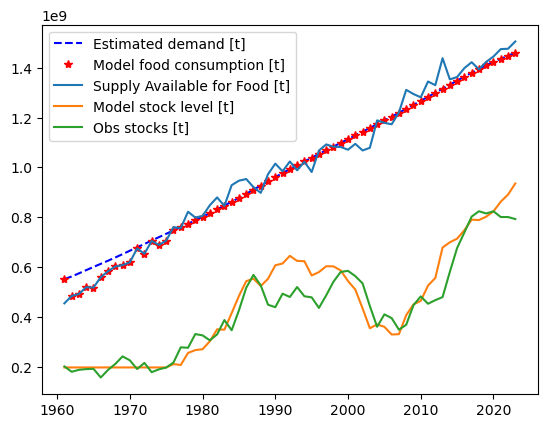

In [454]:
plt.plot(years,1000*Pop_Data.Value.values[11:]*caloric_requirment/cereal_caloric_density*(1+processing),'b--',label='Estimated demand [t]')
plt.plot(years,1000*Pop_Data.Value.values[11:]*caloric_requirment/cereal_caloric_density*(1-alpha+processing),'r*',label='Model food consumption [t]')
plt.plot(years,Production_Data.Value.values*(1-seed-loss-economic_use),label='Supply Available for Food [t]')
plt.plot(years,stocks+stocks_obs[0]*1000,label='Model stock level [t]')
plt.plot(years,1000*np.array(stocks_obs)[1:-1],label='Obs stocks [t]')
#plt.plot(commodity_prices.Year.unique()[61:],1000*np.max(stocks_obs)*mean_price[61:],label='world price')
plt.legend()


In [207]:
commodity_prices = pd.read_csv(r"C:\Users\danie\Downloads\Geronimi-GYPrices-UpTo2020.csv")
commodity_prices.columns 

Index(['Year', 'Coffee', 'Cocoa', 'Tea', 'Rice', 'Wheat', 'Maize', 'Sugar',
       'Beef', 'Lamb', 'Banana', 'Palmoil', 'Cotton', 'Jute', 'Wool', 'Hides',
       'Tobacco', 'Rubber', 'Timber', 'Copper', 'Aluminum', 'Tin', 'Silver',
       'Lead', 'Zinc', 'MUV'],
      dtype='object')

In [450]:
observed_stocks = pd.read_csv(r"C:\Users\danie\Downloads\world_cereal_stocks.csv")
stocks_obs = []
year = []
for column in observed_stocks.columns[3:-1]:
    stocks_obs.append(np.char.replace(observed_stocks[column].values.astype(str), ",", "").astype(float).sum())
    year.append(int(column[0:4]))

# 1-D SUM
- Adding regional units coupled by import/export relationships
- Specify animal use: attempt to reproduce relative stock levels
- then add monthly trade ?

In [ ]:
UNSDA_conventions[UNSDA_conventions["ISO-alpha3 Code"]==national_animalfeed_use.Code.unique()[0]]["Intermediate Region Name"].values[0]

'Asia'

In [437]:
UNSDA_conventions.loc[UNSDA_conventions["Intermediate Region Name"].isna(),"Intermediate Region Name"]=UNSDA_conventions.loc[UNSDA_conventions["Intermediate Region Name"].astype(str)=='nan']["Region Name"]

In [434]:
UNSDA_conventions = pd.read_csv(r"C:\Users\danie\Downloads\UNSD-NamingConventions.csv",delimiter=';')

In [455]:
national_allocations = pd.read_csv(r"C:\Users\danie\Downloads\cereal-allocation-by-country.csv")

In [317]:
regional_production = pd.read_csv(r"C:\Users\danie\Downloads\regional-cereal-production.csv")
regional_trade =  pd.read_csv(r"C:\Users\danie\Downloads\regional-cereal-importexports.csv")
regional_population = pd.read_csv(r"C:\Users\danie\Downloads\FAOSTAT_regionalpopulation.csv")

In [459]:
national_allocations.columns 

Index(['Entity', 'Code', 'Year',
       'Cereals - Excluding Beer | 00002905 || Food | 005142 || tonnes',
       'Cereals - Excluding Beer | 00002905 || Feed | 005521 || tonnes',
       'Cereals - Excluding Beer | 00002905 || Other uses | 005154 || tonnes',
       'Cereals - Excluding Beer | 00002905 || Processing | 005131 || tonnes'],
      dtype='object')

In [ ]:
national_allocations[national_allocations['Entity']==entity]['Cereals - Excluding Beer | 00002905 || Feed | 005521 || tonnes'].values

In [460]:
regional_animalfeed_proportions = {region:[] for region in regional_production.Area.unique()}
regional_other_proportions = {region:[] for region in regional_production.Area.unique()}
regional_processing_proportions = {region:[] for region in regional_production.Area.unique()}

for entity in national_allocations.Entity.unique():
    national_allocations[national_allocations['Entity']==entity]['Cereals - Excluding Beer | 00002905 || Feed | 005521 || tonnes'].values





In [323]:
alpha.shape 

(21, 63)

In [333]:
years[i]

1962

In [337]:
years=years[30:]

In [388]:
seed = 0.03
loss = 0.04
processing = 0.04
economic_use = 0.33  + 0.08+addit# 0*np.hstack([World_otheruse,World_otheruse[-1]])/100 # 35% for animal consumption. World other use is extended by one year. #
cereal_caloric_density = 2609*1000 # kcal/ton 
caloric_requirment = 1240*365 # 1200 kcal/year


stocks = np.zeros((len(regional_production.Area.unique()),len(years)))-0.01
#stocks[0] = stocks_obs[0]*1000
alpha = np.zeros((len(regional_production.Area.unique()),len(years)))
for r,region in enumerate(regional_production.Area.unique()):
    for i in np.arange(1,len(years)):
        Pop = regional_population[(regional_population.Year == years[i]) & (regional_population.Area == region )].Value.values[0] #[1000 people]
        Y = regional_production[(regional_production.Year == years[i]) & (regional_production.Area == region )].Value.values[0] #[tons]
        
        try:
            trade_balance = regional_trade[(regional_trade.Year == years[i]) & (regional_trade.Area == region ) & (regional_trade.Element == 'Import quantity')].Value.values[0] - regional_trade[(regional_trade.Year == years[i]) & (regional_trade.Area == region ) & (regional_trade.Element == 'Export quantity')].Value.values[0] #[tons]
        except:
            trade_balance =0 
            print(region)
            print(years[i])
        food = 1000*Pop*caloric_requirment/cereal_caloric_density # in tons

        if stocks[r,i-1] + (trade_balance+Y*(1-seed-loss) - food*(1+processing-alpha[r,i]) - Y*economic_use[i]) > 0:
            alpha[r,i] = 0
        else:
            alpha[r,i] = -((stocks[r,i-1] + trade_balance + Y*(1-seed-loss) - Y*economic_use[i])/food - (1+processing))
            alpha[r,i] = alpha[r,i].clip(0,1-processing)
        dstock = trade_balance + Y*(1-seed-loss) - food*(1+processing-alpha[r,i]) - Y*economic_use[i]
        stocks[r,i] = stocks[r,i-1] + dstock

Micronesia
1992
Micronesia
1993
Micronesia
1994
Micronesia
1995
Micronesia
1996
Micronesia
1997
Micronesia
1998
Micronesia
1999
Micronesia
2000
Micronesia
2001
Micronesia
2002
Micronesia
2003
Micronesia
2004
Micronesia
2005
Micronesia
2006
Micronesia
2007
Micronesia
2008
Micronesia
2009
Micronesia
2010
Micronesia
2011
Micronesia
2012
Micronesia
2013
Micronesia
2014
Micronesia
2017
Micronesia
2018
Micronesia
2019
Micronesia
2020
Micronesia
2021
Micronesia
2022
Micronesia
2023


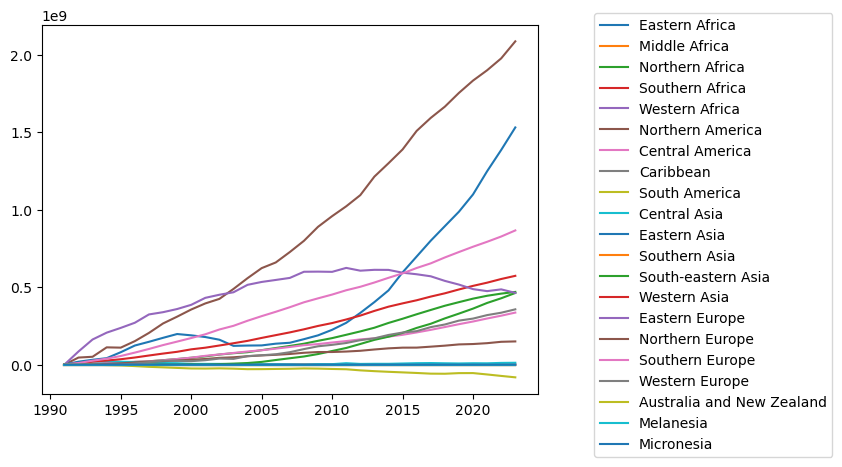

In [390]:
fig = plt.figure()
ax = plt.subplot(111)
for r,region in enumerate(regional_production.Area.unique()):
    if alpha[r,:].mean()>-0.1:
        plt.plot(years,stocks[r,:],label=region)
ax.legend(bbox_to_anchor=(1.1, 1.05))

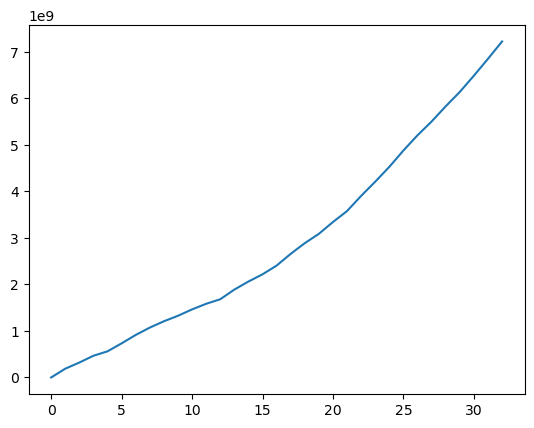

In [375]:
plt.plot(np.sum(stocks,axis=0))